In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/data
No --configs argument given - defaulting to:
/Users/josephbullock/Documents/covidmodelling/JUNE/june/configs


2022-01-28 13:56:49,602 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/camp_data
2022-01-28 13:56:49,603 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [5]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-01-28 13:56:49,959 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [6]:
# populate empty world
populate_world(world)

In [7]:
# distribute people to households
distribute_people_to_households(world)

In [8]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-01-28 13:56:50,657 - hospitals - INFO - There are 8 hospitals in the world.


In [9]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-01-28 13:56:50,687 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-01-28 13:56:50,708 - social_venue - INFO - Domain 0 has 508 play_groups(s)
2022-01-28 13:56:50,715 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-01-28 13:56:50,752 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-01-28 13:56:50,773 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-01-28 13:56:51,187 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-01-28 13:56:51,195 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-01-28 13:56:51,206 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [10]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['m', 'm', 'f', 'm', 'm'], [17, 50, 57, 44, 18])

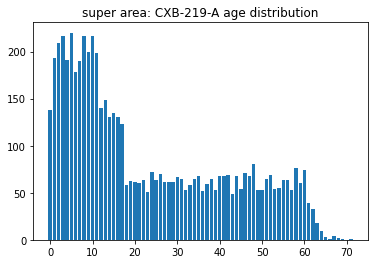

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

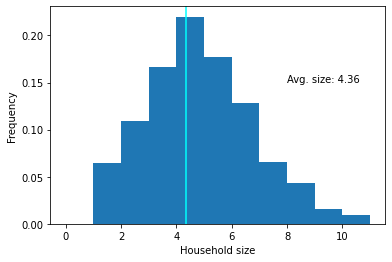

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [20]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

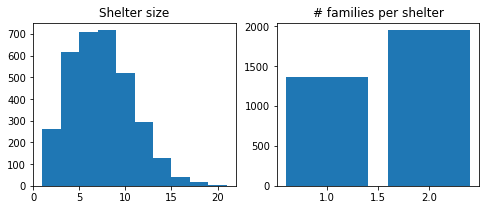

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [22]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [23]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [24]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [25]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [26]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [27]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [28]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [29]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [30]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [31]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [32]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [33]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [34]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [35]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [36]:
selector = InfectionSelector.from_file()

In [37]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [38]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [39]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [40]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [41]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [42]:
infection_seeds = InfectionSeeds([infection_seed])

In [43]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path=camp_configs_path / "defaults/comorbidities.yaml",
    male_comorbidity_reference_prevalence_path= camp_data_path / "input/demography/uk_male_comorbidities.csv",
    female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv",
    
)

In [44]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [45]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [46]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-01-28 13:56:52,591 - leisure - INFO - Linking households and care homes for visits
2022-01-28 13:56:52,591 - leisure - INFO - Done
2022-01-28 13:56:52,591 - leisure - INFO - Distributing social venues to areas
2022-01-28 13:56:52,592 - leisure - INFO - Distributed in 0 of 65 areas.
2022-01-28 13:56:52,666 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [47]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [48]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [49]:
%%time
simulator.run()

2022-01-28 13:56:52,970 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2022-01-28 13:56:53,368 - rank - INFO - Next timestep
2022-01-28 13:56:53,368 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:56:53,533 - rank - INFO - Rank 0 -- move_people -- 0.1642116800000002
2022-01-28 13:56:53,533 - rank - INFO - Rank 0 -- move_people_waiting -- 3.787999999893543e-06
2022-01-28 13:56:53,534 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3300000000503474e-06,1.9073486328125e-06 - 2020-05-24 00:00:00
2022-01-28 13:56:53,541 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 224
2022-01-28 13:56:53,607 - rank - INFO - Rank 0 -- interaction -- 0.072670338
2022-01-28 13:56:53,609 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0013403520000005997,0.0013399124145507812 - 2020-05-24 00:00:00
2022-01-28 13:56:53,722 - rank

2022-01-28 13:56:57,312 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 275
2022-01-28 13:56:57,420 - rank - INFO - Rank 0 -- interaction -- 0.11296627000000115
2022-01-28 13:56:57,423 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002552659999999207,0.0002548694610595703 - 2020-05-25 02:00:00
2022-01-28 13:56:57,453 - rank - INFO - Rank 0 -- interaction_waiting -- 9.700999999751048e-06
2022-01-28 13:56:57,467 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014008844999999326,0.014009952545166016 - 2020-05-25 02:00:00

2022-01-28 13:56:57,469 - rank - INFO - Next timestep
2022-01-28 13:56:57,470 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:56:57,866 - rank - INFO - Rank 0 -- move_people -- 0.3955104259999995
2022-01-28 13:56:57,866 - rank - INFO - Rank 0 -- move_people_waiting -- 3.899999999390502e-06
2022-01-28 13:56:57,867 - activity_manager - INFO - CMS: Peopl

2022-01-28 13:57:00,834 - rank - INFO - Next timestep
2022-01-28 13:57:00,834 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:01,217 - rank - INFO - Rank 0 -- move_people -- 0.3825090299999996
2022-01-28 13:57:01,218 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4749999997529812e-06
2022-01-28 13:57:01,218 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.559000001374102e-06,3.0994415283203125e-05 - 2020-05-26 06:00:00
2022-01-28 13:57:01,226 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 372
2022-01-28 13:57:01,327 - rank - INFO - Rank 0 -- interaction -- 0.10780601899999986
2022-01-28 13:57:01,330 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00030055199999878823,0.0002999305725097656 - 2020-05-26 06:00:00
2022-01-28 13:57:01,358 - rank - INFO - Rank 0 -- interaction_waiting -- 9.578100000062761e-05
2022-01-28 13:57:01,371 - simulator - INFO - CMS

2022-01-28 13:57:04,680 - rank - INFO - Rank 0 -- interaction -- 0.1099350269999988
2022-01-28 13:57:04,684 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00048530000000113205,0.00048470497131347656 - 2020-05-27 08:00:00
2022-01-28 13:57:04,715 - rank - INFO - Rank 0 -- interaction_waiting -- 9.378000001447617e-06
2022-01-28 13:57:04,728 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012582480999999035,0.01258397102355957 - 2020-05-27 08:00:00

2022-01-28 13:57:04,729 - rank - INFO - Next timestep
2022-01-28 13:57:04,730 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:04,907 - rank - INFO - Rank 0 -- move_people -- 0.17670892900000013
2022-01-28 13:57:04,908 - rank - INFO - Rank 0 -- move_people_waiting -- 3.68299999919941e-06
2022-01-28 13:57:04,908 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4799999991387267e-06,2.1457672119140625e-06 - 2020-05-27 10:00:00
2022-01-28 13:57:04,913 - simulator - INFO - Inf

2022-01-28 13:57:08,106 - rank - INFO - Rank 0 -- move_people -- 0.17118847200000076
2022-01-28 13:57:08,106 - rank - INFO - Rank 0 -- move_people_waiting -- 3.271000000637514e-06
2022-01-28 13:57:08,107 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.936000001341199e-06,2.86102294921875e-06 - 2020-05-29 00:00:00
2022-01-28 13:57:08,112 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 715
2022-01-28 13:57:08,174 - rank - INFO - Rank 0 -- interaction -- 0.06616697999999843
2022-01-28 13:57:08,182 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0011593110000021056,0.0011577606201171875 - 2020-05-29 00:00:00
2022-01-28 13:57:08,212 - rank - INFO - Rank 0 -- interaction_waiting -- 8.148999999235684e-06
2022-01-28 13:57:08,224 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012594594999999487,0.01259613037109375 - 2020-05-29 00:00:00

2022-01-28 13:57:08,226 - rank - INFO - Next timestep
2022-01-2

2022-01-28 13:57:11,704 - rank - INFO - Rank 0 -- interaction_waiting -- 8.44799999910606e-06
2022-01-28 13:57:11,716 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01219794200000024,0.012199163436889648 - 2020-05-30 03:00:00

2022-01-28 13:57:11,718 - rank - INFO - Next timestep
2022-01-28 13:57:11,718 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:12,122 - rank - INFO - Rank 0 -- move_people -- 0.4031854209999999
2022-01-28 13:57:12,123 - rank - INFO - Rank 0 -- move_people_waiting -- 6.089999999403517e-06
2022-01-28 13:57:12,123 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3590000008132392e-06,3.0994415283203125e-06 - 2020-05-30 05:00:00
2022-01-28 13:57:12,128 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 873
2022-01-28 13:57:12,242 - rank - INFO - Rank 0 -- interaction -- 0.1186722859999989
2022-01-28 13:57:12,248 - epidemiology - INFO - CMS: Infection CO

2022-01-28 13:57:15,659 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2870000009334035e-06,2.1457672119140625e-06 - 2020-05-31 07:00:00
2022-01-28 13:57:15,664 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1019
2022-01-28 13:57:15,777 - rank - INFO - Rank 0 -- interaction -- 0.117374587999997
2022-01-28 13:57:15,782 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021379599999704624,0.00021338462829589844 - 2020-05-31 07:00:00
2022-01-28 13:57:15,812 - rank - INFO - Rank 0 -- interaction_waiting -- 8.342000000993721e-06
2022-01-28 13:57:15,824 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012030697000000146,0.01203298568725586 - 2020-05-31 07:00:00

2022-01-28 13:57:15,825 - rank - INFO - Next timestep
2022-01-28 13:57:15,826 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:16,221 - rank - INFO - Rank 0 -- move_people -- 0.3946752199999999
2022-

2022-01-28 13:57:19,358 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013389416999999071,0.01339101791381836 - 2020-06-01 08:00:00

2022-01-28 13:57:19,359 - rank - INFO - Next timestep
2022-01-28 13:57:19,360 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:19,541 - rank - INFO - Rank 0 -- move_people -- 0.1804179459999986
2022-01-28 13:57:19,542 - rank - INFO - Rank 0 -- move_people_waiting -- 3.880000001288408e-06
2022-01-28 13:57:19,542 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7359999990039796e-06,1.9073486328125e-06 - 2020-06-01 10:00:00
2022-01-28 13:57:19,547 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1184
2022-01-28 13:57:19,628 - rank - INFO - Rank 0 -- interaction -- 0.08546569499999634
2022-01-28 13:57:19,656 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004793169999999236,0.00047898292541503906 - 2020-06-01 10:00:00
2022-01

2022-01-28 13:57:23,111 - simulator - INFO - Info for rank 0, Date = 2020-06-03 00:00:00, number of deaths =  0, number of infected = 1400
2022-01-28 13:57:23,181 - rank - INFO - Rank 0 -- interaction -- 0.07443956999999557
2022-01-28 13:57:23,186 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005318699999961041,0.0005309581756591797 - 2020-06-03 00:00:00
2022-01-28 13:57:23,224 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0900999996010796e-05
2022-01-28 13:57:23,237 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013544687999996086,0.013546228408813477 - 2020-06-03 00:00:00

2022-01-28 13:57:23,239 - rank - INFO - Next timestep
2022-01-28 13:57:23,240 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:23,654 - rank - INFO - Rank 0 -- move_people -- 0.4135721859999961
2022-01-28 13:57:23,654 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3550000040349914e-06
2022-01-28 13:57:23,655 - activity_manager - INFO - CMS: Pe

2022-01-28 13:57:26,914 - rank - INFO - Next timestep
2022-01-28 13:57:26,915 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:27,320 - rank - INFO - Rank 0 -- move_people -- 0.4049465639999994
2022-01-28 13:57:27,321 - rank - INFO - Rank 0 -- move_people_waiting -- 7.617700000395189e-05
2022-01-28 13:57:27,321 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.039999995735343e-06,3.0994415283203125e-06 - 2020-06-04 04:00:00
2022-01-28 13:57:27,326 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 1570
2022-01-28 13:57:27,477 - rank - INFO - Rank 0 -- interaction -- 0.15550844700000255
2022-01-28 13:57:27,486 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005318029999941132,0.000530242919921875 - 2020-06-04 04:00:00
2022-01-28 13:57:27,528 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2943999998071831e-05
2022-01-28 13:57:27,543 - simulator - INFO - CMS:

2022-01-28 13:57:31,908 - rank - INFO - Rank 0 -- interaction -- 0.15984643800000242
2022-01-28 13:57:31,915 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00037823099999911847,0.0003769397735595703 - 2020-06-05 06:00:00
2022-01-28 13:57:31,955 - rank - INFO - Rank 0 -- interaction_waiting -- 9.785999999678552e-06
2022-01-28 13:57:31,968 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013056312999999875,0.013057947158813477 - 2020-06-05 06:00:00

2022-01-28 13:57:31,970 - rank - INFO - Next timestep
2022-01-28 13:57:31,971 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:32,421 - rank - INFO - Rank 0 -- move_people -- 0.4502302640000053
2022-01-28 13:57:32,422 - rank - INFO - Rank 0 -- move_people_waiting -- 5.459499999460604e-05
2022-01-28 13:57:32,423 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4369999991336044e-06,2.1457672119140625e-06 - 2020-06-05 08:00:00
2022-01-28 13:57:32,428 - simulator - INFO - In

2022-01-28 13:57:36,018 - rank - INFO - Rank 0 -- move_people -- 0.1988640769999961
2022-01-28 13:57:36,018 - rank - INFO - Rank 0 -- move_people_waiting -- 4.419999996230217e-06
2022-01-28 13:57:36,019 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9179999998518724e-06,1.9073486328125e-06 - 2020-06-06 11:00:00
2022-01-28 13:57:36,024 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 1941
2022-01-28 13:57:36,113 - rank - INFO - Rank 0 -- interaction -- 0.09350463400000564
2022-01-28 13:57:36,142 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029766800000174953,0.0002980232238769531 - 2020-06-06 11:00:00
2022-01-28 13:57:36,184 - rank - INFO - Rank 0 -- interaction_waiting -- 8.536999999364525e-06
2022-01-28 13:57:36,197 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012671124000000589,0.012673139572143555 - 2020-06-06 11:00:00

2022-01-28 13:57:36,198 - rank - INFO - Next timestep
2022-01

2022-01-28 13:57:39,736 - rank - INFO - Rank 0 -- interaction_waiting -- 9.122999998112391e-06
2022-01-28 13:57:39,749 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012048591999999303,0.012048006057739258 - 2020-06-08 00:00:00

2022-01-28 13:57:39,750 - rank - INFO - Next timestep
2022-01-28 13:57:39,751 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:40,160 - rank - INFO - Rank 0 -- move_people -- 0.4088027210000007
2022-01-28 13:57:40,161 - rank - INFO - Rank 0 -- move_people_waiting -- 3.385200000138866e-05
2022-01-28 13:57:40,162 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7620000011552293e-06,1.9073486328125e-06 - 2020-06-08 02:00:00
2022-01-28 13:57:40,167 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 2196
2022-01-28 13:57:40,327 - rank - INFO - Rank 0 -- interaction -- 0.16522072000000065
2022-01-28 13:57:40,339 - epidemiology - INFO - CMS: Infection C

2022-01-28 13:57:43,979 - simulator - INFO - Info for rank 0, Date = 2020-06-09 04:00:00, number of deaths =  1, number of infected = 2363
2022-01-28 13:57:44,106 - rank - INFO - Rank 0 -- interaction -- 0.13338389500000147
2022-01-28 13:57:44,114 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016098500000083504,0.0001609325408935547 - 2020-06-09 04:00:00
2022-01-28 13:57:44,150 - rank - INFO - Rank 0 -- interaction_waiting -- 8.399999998687235e-06
2022-01-28 13:57:44,162 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012245223999997279,0.012245893478393555 - 2020-06-09 04:00:00

2022-01-28 13:57:44,164 - rank - INFO - Next timestep
2022-01-28 13:57:44,164 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:44,564 - rank - INFO - Rank 0 -- move_people -- 0.39936628800000307
2022-01-28 13:57:44,565 - rank - INFO - Rank 0 -- move_people_waiting -- 4.992999997455172e-06
2022-01-28 13:57:44,565 - activity_manager - INFO - CMS: Pe

2022-01-28 13:57:47,807 - rank - INFO - Next timestep
2022-01-28 13:57:47,808 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:48,218 - rank - INFO - Rank 0 -- move_people -- 0.4093103909999982
2022-01-28 13:57:48,218 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6630000010973163e-06
2022-01-28 13:57:48,219 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2449999949335506e-06,3.0994415283203125e-06 - 2020-06-10 08:00:00
2022-01-28 13:57:48,224 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  1, number of infected = 2550
2022-01-28 13:57:48,362 - rank - INFO - Rank 0 -- interaction -- 0.14222338100000087
2022-01-28 13:57:48,371 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002365650000015762,0.00023603439331054688 - 2020-06-10 08:00:00
2022-01-28 13:57:48,410 - rank - INFO - Rank 0 -- interaction_waiting -- 8.612999998547366e-06
2022-01-28 13:57:48,423 - simulator - INFO - C

2022-01-28 13:57:51,944 - rank - INFO - Rank 0 -- interaction -- 0.09539643300000478
2022-01-28 13:57:51,976 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004201449999925444,0.0004200935363769531 - 2020-06-11 10:00:00
2022-01-28 13:57:52,021 - rank - INFO - Rank 0 -- interaction_waiting -- 9.855000001834924e-06
2022-01-28 13:57:52,035 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014847532000004549,0.014848947525024414 - 2020-06-11 10:00:00

2022-01-28 13:57:52,037 - rank - INFO - Next timestep
2022-01-28 13:57:52,038 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:57:52,266 - rank - INFO - Rank 0 -- move_people -- 0.22772315599999615
2022-01-28 13:57:52,267 - rank - INFO - Rank 0 -- move_people_waiting -- 6.202399998755936e-05
2022-01-28 13:57:52,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1050000046661808e-06,2.86102294921875e-06 - 2020-06-12 00:00:00
2022-01-28 13:57:52,273 - simulator - INFO - Info

2022-01-28 13:57:56,223 - rank - INFO - Rank 0 -- move_people -- 0.516099674000003
2022-01-28 13:57:56,224 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7740000067287838e-06
2022-01-28 13:57:56,225 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.058000004330097e-06,1.9073486328125e-06 - 2020-06-13 03:00:00
2022-01-28 13:57:56,231 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  1, number of infected = 2931
2022-01-28 13:57:56,393 - rank - INFO - Rank 0 -- interaction -- 0.1674372779999942
2022-01-28 13:57:56,404 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019321599999955197,0.0001919269561767578 - 2020-06-13 03:00:00
2022-01-28 13:57:56,449 - rank - INFO - Rank 0 -- interaction_waiting -- 8.889000000067426e-06
2022-01-28 13:57:56,462 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01319270199999778,0.013195037841796875 - 2020-06-13 03:00:00

2022-01-28 13:57:56,464 - rank - INFO - Next timestep
2022-01-28

2022-01-28 13:58:00,322 - rank - INFO - Rank 0 -- interaction_waiting -- 8.809000007659051e-06
2022-01-28 13:58:00,335 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012419447000013406,0.012420892715454102 - 2020-06-14 05:00:00

2022-01-28 13:58:00,336 - rank - INFO - Next timestep
2022-01-28 13:58:00,337 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:00,760 - rank - INFO - Rank 0 -- move_people -- 0.4228437590000027
2022-01-28 13:58:00,760 - rank - INFO - Rank 0 -- move_people_waiting -- 3.52799999348008e-06
2022-01-28 13:58:00,761 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.660000006926566e-06,1.9073486328125e-06 - 2020-06-14 07:00:00
2022-01-28 13:58:00,766 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  1, number of infected = 3107
2022-01-28 13:58:00,912 - rank - INFO - Rank 0 -- interaction -- 0.15060320599999955
2022-01-28 13:58:00,920 - epidemiology - INFO - CMS: Infection COM

2022-01-28 13:58:04,612 - simulator - INFO - Info for rank 0, Date = 2020-06-15 08:00:00, number of deaths =  1, number of infected = 3273
2022-01-28 13:58:04,749 - rank - INFO - Rank 0 -- interaction -- 0.1418608259999985
2022-01-28 13:58:04,758 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043072999999083095,0.0004298686981201172 - 2020-06-15 08:00:00
2022-01-28 13:58:04,800 - rank - INFO - Rank 0 -- interaction_waiting -- 9.321000007389557e-06
2022-01-28 13:58:04,813 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01247724099999914,0.012479066848754883 - 2020-06-15 08:00:00

2022-01-28 13:58:04,814 - rank - INFO - Next timestep
2022-01-28 13:58:04,815 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:04,996 - rank - INFO - Rank 0 -- move_people -- 0.18094413400000064
2022-01-28 13:58:04,997 - rank - INFO - Rank 0 -- move_people_waiting -- 3.430999996112405e-06
2022-01-28 13:58:04,997 - activity_manager - INFO - CMS: Peop

2022-01-28 13:58:08,443 - rank - INFO - Next timestep
2022-01-28 13:58:08,443 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:08,629 - rank - INFO - Rank 0 -- move_people -- 0.18527796099999705
2022-01-28 13:58:08,630 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6250000050586095e-06
2022-01-28 13:58:08,630 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.567999999314452e-06,3.0994415283203125e-06 - 2020-06-17 00:00:00
2022-01-28 13:58:08,635 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  2, number of infected = 3475
2022-01-28 13:58:08,717 - rank - INFO - Rank 0 -- interaction -- 0.08678049300000623
2022-01-28 13:58:08,726 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00046056400000793474,0.0004591941833496094 - 2020-06-17 00:00:00
2022-01-28 13:58:08,772 - rank - INFO - Rank 0 -- interaction_waiting -- 8.997000009003386e-06
2022-01-28 13:58:08,785 - simulator - INFO - C

2022-01-28 13:58:12,649 - rank - INFO - Rank 0 -- interaction -- 0.16132487499999115
2022-01-28 13:58:12,658 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007713970000082782,0.0007700920104980469 - 2020-06-18 02:00:00
2022-01-28 13:58:12,704 - rank - INFO - Rank 0 -- interaction_waiting -- 9.417999990546377e-06
2022-01-28 13:58:12,717 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012166894999992905,0.012166976928710938 - 2020-06-18 02:00:00

2022-01-28 13:58:12,718 - rank - INFO - Next timestep
2022-01-28 13:58:12,719 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:13,128 - rank - INFO - Rank 0 -- move_people -- 0.4086621360000038
2022-01-28 13:58:13,129 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0002313160000113612
2022-01-28 13:58:13,130 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7829999993400634e-06,3.0994415283203125e-06 - 2020-06-18 04:00:00
2022-01-28 13:58:13,135 - simulator - INFO - Inf

2022-01-28 13:58:17,141 - rank - INFO - Rank 0 -- move_people -- 0.40384633600000086
2022-01-28 13:58:17,141 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7450000007765993e-06
2022-01-28 13:58:17,142 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6640000072575276e-06,3.0994415283203125e-06 - 2020-06-19 06:00:00
2022-01-28 13:58:17,147 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  2, number of infected = 3702
2022-01-28 13:58:17,289 - rank - INFO - Rank 0 -- interaction -- 0.1466346969999961
2022-01-28 13:58:17,295 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004943750000023783,0.0004940032958984375 - 2020-06-19 06:00:00
2022-01-28 13:58:17,342 - rank - INFO - Rank 0 -- interaction_waiting -- 8.273999995367376e-06
2022-01-28 13:58:17,356 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014031331999987628,0.014032840728759766 - 2020-06-19 06:00:00

2022-01-28 13:58:17,357 - rank - INFO - Next timestep
2022

2022-01-28 13:58:21,185 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00035996699999429893
2022-01-28 13:58:21,198 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013088421999995603,0.013089895248413086 - 2020-06-20 09:00:00

2022-01-28 13:58:21,200 - rank - INFO - Next timestep
2022-01-28 13:58:21,201 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:21,381 - rank - INFO - Rank 0 -- move_people -- 0.17887079700000186
2022-01-28 13:58:21,382 - rank - INFO - Rank 0 -- move_people_waiting -- 5.172000001607557e-06
2022-01-28 13:58:21,382 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7119999970182107e-06,2.1457672119140625e-06 - 2020-06-20 11:00:00
2022-01-28 13:58:21,387 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  2, number of infected = 3811
2022-01-28 13:58:21,490 - rank - INFO - Rank 0 -- interaction -- 0.10730871600000569
2022-01-28 13:58:21,524 - epidemiology - INFO - CMS: Infect

2022-01-28 13:58:25,132 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2169999997222476e-06,3.0994415283203125e-06 - 2020-06-22 00:00:00
2022-01-28 13:58:25,137 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  2, number of infected = 3925
2022-01-28 13:58:25,232 - rank - INFO - Rank 0 -- interaction -- 0.09936697200001277
2022-01-28 13:58:25,238 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003367460000021083,0.000335693359375 - 2020-06-22 00:00:00
2022-01-28 13:58:25,285 - rank - INFO - Rank 0 -- interaction_waiting -- 1.249199999620032e-05
2022-01-28 13:58:25,297 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012354821000002403,0.012350797653198242 - 2020-06-22 00:00:00

2022-01-28 13:58:25,299 - rank - INFO - Next timestep
2022-01-28 13:58:25,299 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:25,701 - rank - INFO - Rank 0 -- move_people -- 0.4008543099999997
2022-01-

2022-01-28 13:58:29,487 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013726861999998619,0.013729095458984375 - 2020-06-23 02:00:00

2022-01-28 13:58:29,488 - rank - INFO - Next timestep
2022-01-28 13:58:29,489 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:30,065 - rank - INFO - Rank 0 -- move_people -- 0.5754854870000088
2022-01-28 13:58:30,066 - rank - INFO - Rank 0 -- move_people_waiting -- 7.148500000653257e-05
2022-01-28 13:58:30,066 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5590000067031724e-06,3.814697265625e-06 - 2020-06-23 04:00:00
2022-01-28 13:58:30,073 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  2, number of infected = 4054
2022-01-28 13:58:30,231 - rank - INFO - Rank 0 -- interaction -- 0.1644990679999978
2022-01-28 13:58:30,239 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027509899999245135,0.00027489662170410156 - 2020-06-23 04:00:00
2022-01

2022-01-28 13:58:34,276 - simulator - INFO - Info for rank 0, Date = 2020-06-24 06:00:00, number of deaths =  2, number of infected = 4118
2022-01-28 13:58:34,429 - rank - INFO - Rank 0 -- interaction -- 0.15736539400000993
2022-01-28 13:58:34,436 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039274600000283044,0.00039196014404296875 - 2020-06-24 06:00:00
2022-01-28 13:58:34,485 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3029999990976648e-05
2022-01-28 13:58:34,498 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01317851599999642,0.013180017471313477 - 2020-06-24 06:00:00

2022-01-28 13:58:34,500 - rank - INFO - Next timestep
2022-01-28 13:58:34,500 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:34,981 - rank - INFO - Rank 0 -- move_people -- 0.4796394760000027
2022-01-28 13:58:34,981 - rank - INFO - Rank 0 -- move_people_waiting -- 5.770699999629869e-05
2022-01-28 13:58:34,982 - activity_manager - INFO - CMS: Pe

2022-01-28 13:58:39,383 - rank - INFO - Next timestep
2022-01-28 13:58:39,384 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:39,644 - rank - INFO - Rank 0 -- move_people -- 0.2599819750000023
2022-01-28 13:58:39,645 - rank - INFO - Rank 0 -- move_people_waiting -- 3.976000002126057e-06
2022-01-28 13:58:39,645 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.043000006641705e-06,2.1457672119140625e-06 - 2020-06-25 10:00:00
2022-01-28 13:58:39,652 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  2, number of infected = 4172
2022-01-28 13:58:39,805 - rank - INFO - Rank 0 -- interaction -- 0.1591737570000049
2022-01-28 13:58:39,868 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008832449999971459,0.0008828639984130859 - 2020-06-25 10:00:00
2022-01-28 13:58:39,936 - rank - INFO - Rank 0 -- interaction_waiting -- 8.774999997740451e-06
2022-01-28 13:58:39,950 - simulator - INFO - CMS: 

2022-01-28 13:58:44,342 - rank - INFO - Rank 0 -- interaction -- 0.12004491500000825
2022-01-28 13:58:44,354 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017840799999646606,0.00017690658569335938 - 2020-06-27 00:00:00
2022-01-28 13:58:44,405 - rank - INFO - Rank 0 -- interaction_waiting -- 8.698999991452183e-06
2022-01-28 13:58:44,417 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012315974999992818,0.012316703796386719 - 2020-06-27 00:00:00

2022-01-28 13:58:44,419 - rank - INFO - Next timestep
2022-01-28 13:58:44,419 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:44,883 - rank - INFO - Rank 0 -- move_people -- 0.4630824599999954
2022-01-28 13:58:44,884 - rank - INFO - Rank 0 -- move_people_waiting -- 6.86479999956191e-05
2022-01-28 13:58:44,884 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.825000004871072e-06,4.291534423828125e-06 - 2020-06-27 03:00:00
2022-01-28 13:58:44,891 - simulator - INFO - Info

2022-01-28 13:58:49,071 - rank - INFO - Rank 0 -- move_people -- 0.4103738630000038
2022-01-28 13:58:49,072 - rank - INFO - Rank 0 -- move_people_waiting -- 1.5531000002511064e-05
2022-01-28 13:58:49,073 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.508000006036127e-06,3.0994415283203125e-06 - 2020-06-28 05:00:00
2022-01-28 13:58:49,081 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  2, number of infected = 4317
2022-01-28 13:58:49,251 - rank - INFO - Rank 0 -- interaction -- 0.17761404299999128
2022-01-28 13:58:49,257 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00037499299999410596,0.0003750324249267578 - 2020-06-28 05:00:00
2022-01-28 13:58:49,308 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2716000000523309e-05
2022-01-28 13:58:49,320 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01247683600000471,0.012478351593017578 - 2020-06-28 05:00:00

2022-01-28 13:58:49,322 - rank - INFO - Next timestep
2022

2022-01-28 13:58:53,355 - rank - INFO - Rank 0 -- interaction_waiting -- 8.418999996706589e-06
2022-01-28 13:58:53,367 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011860993999988523,0.011861324310302734 - 2020-06-29 06:00:00

2022-01-28 13:58:53,369 - rank - INFO - Next timestep
2022-01-28 13:58:53,369 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:53,775 - rank - INFO - Rank 0 -- move_people -- 0.4052032570000108
2022-01-28 13:58:53,775 - rank - INFO - Rank 0 -- move_people_waiting -- 3.317999997420884e-06
2022-01-28 13:58:53,776 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 1.8084000004137124e-05,1.7881393432617188e-05 - 2020-06-29 08:00:00
2022-01-28 13:58:53,781 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  2, number of infected = 4332
2022-01-28 13:58:53,934 - rank - INFO - Rank 0 -- interaction -- 0.15716126700000643
2022-01-28 13:58:53,941 - epidemiology - INFO - CMS: Infectio

2022-01-28 13:58:57,751 - simulator - INFO - Info for rank 0, Date = 2020-06-30 10:00:00, number of deaths =  2, number of infected = 4399
2022-01-28 13:58:57,874 - rank - INFO - Rank 0 -- interaction -- 0.12847189999999387
2022-01-28 13:58:57,913 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018435699999486133,0.00018310546875 - 2020-06-30 10:00:00
2022-01-28 13:58:57,960 - rank - INFO - Rank 0 -- interaction_waiting -- 8.710000003020468e-06
2022-01-28 13:58:57,971 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011391303000010566,0.011392831802368164 - 2020-06-30 10:00:00

2022-01-28 13:58:57,972 - rank - INFO - Next timestep
2022-01-28 13:58:57,973 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:58:58,162 - rank - INFO - Rank 0 -- move_people -- 0.18839422400000672
2022-01-28 13:58:58,163 - rank - INFO - Rank 0 -- move_people_waiting -- 3.581000015628888e-06
2022-01-28 13:58:58,164 - activity_manager - INFO - CMS: People 

2022-01-28 13:59:01,910 - rank - INFO - Next timestep
2022-01-28 13:59:01,911 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:02,313 - rank - INFO - Rank 0 -- move_people -- 0.40189747700000567
2022-01-28 13:59:02,314 - rank - INFO - Rank 0 -- move_people_waiting -- 3.735000007054623e-06
2022-01-28 13:59:02,314 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.595000012206583e-06,3.0994415283203125e-06 - 2020-07-02 02:00:00
2022-01-28 13:59:02,320 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  3, number of infected = 4475
2022-01-28 13:59:02,475 - rank - INFO - Rank 0 -- interaction -- 0.16033762800000773
2022-01-28 13:59:02,482 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005224889999908555,0.0005218982696533203 - 2020-07-02 02:00:00
2022-01-28 13:59:02,528 - rank - INFO - Rank 0 -- interaction_waiting -- 8.683000004339192e-06
2022-01-28 13:59:02,540 - simulator - INFO - CMS

2022-01-28 13:59:06,682 - rank - INFO - Rank 0 -- interaction -- 0.16136710699998957
2022-01-28 13:59:06,689 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002629130000002533,0.0002627372741699219 - 2020-07-03 04:00:00
2022-01-28 13:59:06,736 - rank - INFO - Rank 0 -- interaction_waiting -- 9.493000021620901e-06
2022-01-28 13:59:06,748 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01199855500001945,0.011998891830444336 - 2020-07-03 04:00:00

2022-01-28 13:59:06,749 - rank - INFO - Next timestep
2022-01-28 13:59:06,750 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:07,164 - rank - INFO - Rank 0 -- move_people -- 0.4133185559999788
2022-01-28 13:59:07,165 - rank - INFO - Rank 0 -- move_people_waiting -- 7.436999993615245e-06
2022-01-28 13:59:07,165 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.289999997628911e-06,2.1457672119140625e-06 - 2020-07-03 06:00:00
2022-01-28 13:59:07,170 - simulator - INFO - Info 

2022-01-28 13:59:11,165 - rank - INFO - Rank 0 -- move_people -- 0.4129769040000042
2022-01-28 13:59:11,166 - rank - INFO - Rank 0 -- move_people_waiting -- 4.016000019646526e-06
2022-01-28 13:59:11,166 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4619999976494e-06,2.1457672119140625e-06 - 2020-07-04 09:00:00
2022-01-28 13:59:11,172 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  3, number of infected = 4608
2022-01-28 13:59:11,330 - rank - INFO - Rank 0 -- interaction -- 0.16293698399999812
2022-01-28 13:59:11,337 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023265999999466658,0.00023221969604492188 - 2020-07-04 09:00:00
2022-01-28 13:59:11,389 - rank - INFO - Rank 0 -- interaction_waiting -- 8.41100001025552e-06
2022-01-28 13:59:11,401 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012063995000005434,0.012063980102539062 - 2020-07-04 09:00:00

2022-01-28 13:59:11,402 - rank - INFO - Next timestep
2022-01

2022-01-28 13:59:15,179 - rank - INFO - Rank 0 -- interaction_waiting -- 9.378000015658472e-06
2022-01-28 13:59:15,191 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011913684000006697,0.011914968490600586 - 2020-07-05 11:00:00

2022-01-28 13:59:15,192 - rank - INFO - Next timestep
2022-01-28 13:59:15,193 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:15,381 - rank - INFO - Rank 0 -- move_people -- 0.1874091209999733
2022-01-28 13:59:15,381 - rank - INFO - Rank 0 -- move_people_waiting -- 4.794999995283433e-06
2022-01-28 13:59:15,382 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.875999996376777e-06,2.86102294921875e-06 - 2020-07-06 00:00:00
2022-01-28 13:59:15,388 - simulator - INFO - Info for rank 0, Date = 2020-07-06 00:00:00, number of deaths =  3, number of infected = 4622
2022-01-28 13:59:15,503 - rank - INFO - Rank 0 -- interaction -- 0.12080526900001587
2022-01-28 13:59:15,510 - epidemiology - INFO - CMS: Infection C

2022-01-28 13:59:19,534 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1929999977364787e-06,3.0994415283203125e-06 - 2020-07-07 02:00:00
2022-01-28 13:59:19,539 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  4, number of infected = 4638
2022-01-28 13:59:19,697 - rank - INFO - Rank 0 -- interaction -- 0.16270706200000973
2022-01-28 13:59:19,705 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001540300000044681,0.00015306472778320312 - 2020-07-07 02:00:00
2022-01-28 13:59:19,754 - rank - INFO - Rank 0 -- interaction_waiting -- 8.772000001044944e-06
2022-01-28 13:59:19,766 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01201374200002192,0.012014150619506836 - 2020-07-07 02:00:00

2022-01-28 13:59:19,767 - rank - INFO - Next timestep
2022-01-28 13:59:19,768 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:20,170 - rank - INFO - Rank 0 -- move_people -- 0.40210169200000223
202

2022-01-28 13:59:23,877 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011917124999996531,0.011918067932128906 - 2020-07-08 04:00:00

2022-01-28 13:59:23,879 - rank - INFO - Next timestep
2022-01-28 13:59:23,879 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:24,273 - rank - INFO - Rank 0 -- move_people -- 0.3928421280000123
2022-01-28 13:59:24,274 - rank - INFO - Rank 0 -- move_people_waiting -- 1.2083000001439359e-05
2022-01-28 13:59:24,274 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2910000154752197e-06,2.1457672119140625e-06 - 2020-07-08 06:00:00
2022-01-28 13:59:24,280 - simulator - INFO - Info for rank 0, Date = 2020-07-08 06:00:00, number of deaths =  4, number of infected = 4657
2022-01-28 13:59:24,435 - rank - INFO - Rank 0 -- interaction -- 0.15992650999999114
2022-01-28 13:59:24,441 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00036755299998958435,0.0003669261932373047 - 2020-07-08 06:00:00
20

2022-01-28 13:59:28,256 - simulator - INFO - Info for rank 0, Date = 2020-07-09 08:00:00, number of deaths =  4, number of infected = 4681
2022-01-28 13:59:28,416 - rank - INFO - Rank 0 -- interaction -- 0.1642199949999963
2022-01-28 13:59:28,429 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006248100000050272,0.0006241798400878906 - 2020-07-09 08:00:00
2022-01-28 13:59:28,477 - rank - INFO - Rank 0 -- interaction_waiting -- 8.45700000695615e-06
2022-01-28 13:59:28,490 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012871062000016309,0.012872934341430664 - 2020-07-09 08:00:00

2022-01-28 13:59:28,491 - rank - INFO - Next timestep
2022-01-28 13:59:28,492 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:28,672 - rank - INFO - Rank 0 -- move_people -- 0.17969294099998478
2022-01-28 13:59:28,673 - rank - INFO - Rank 0 -- move_people_waiting -- 4.994999983409798e-06
2022-01-28 13:59:28,673 - activity_manager - INFO - CMS: Peopl

2022-01-28 13:59:32,396 - rank - INFO - Next timestep
2022-01-28 13:59:32,396 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:32,581 - rank - INFO - Rank 0 -- move_people -- 0.18399451099998032
2022-01-28 13:59:32,581 - rank - INFO - Rank 0 -- move_people_waiting -- 3.650999985893577e-06
2022-01-28 13:59:32,582 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.376999987063755e-06,1.9073486328125e-06 - 2020-07-11 00:00:00
2022-01-28 13:59:32,587 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  4, number of infected = 4664
2022-01-28 13:59:32,694 - rank - INFO - Rank 0 -- interaction -- 0.11193084399999975
2022-01-28 13:59:32,701 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002511759999777041,0.00025081634521484375 - 2020-07-11 00:00:00
2022-01-28 13:59:32,749 - rank - INFO - Rank 0 -- interaction_waiting -- 8.654999987811607e-06
2022-01-28 13:59:32,761 - simulator - INFO - CMS: 

2022-01-28 13:59:36,892 - rank - INFO - Rank 0 -- interaction -- 0.21808772599999315
2022-01-28 13:59:36,901 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024425000000860564,0.0002429485321044922 - 2020-07-12 03:00:00
2022-01-28 13:59:36,963 - rank - INFO - Rank 0 -- interaction_waiting -- 9.432000013021025e-06
2022-01-28 13:59:36,978 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015335397000001194,0.015336990356445312 - 2020-07-12 03:00:00

2022-01-28 13:59:36,980 - rank - INFO - Next timestep
2022-01-28 13:59:36,981 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:37,411 - rank - INFO - Rank 0 -- move_people -- 0.4284264489999998
2022-01-28 13:59:37,411 - rank - INFO - Rank 0 -- move_people_waiting -- 3.503699997509102e-05
2022-01-28 13:59:37,412 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3030000022572494e-06,2.1457672119140625e-06 - 2020-07-12 05:00:00
2022-01-28 13:59:37,417 - simulator - INFO - In

2022-01-28 13:59:41,620 - rank - INFO - Rank 0 -- move_people -- 0.4045215299999825
2022-01-28 13:59:41,621 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00015622800000869574
2022-01-28 13:59:41,622 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.334000015480342e-06,3.0994415283203125e-06 - 2020-07-13 06:00:00
2022-01-28 13:59:41,627 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  5, number of infected = 4726
2022-01-28 13:59:41,818 - rank - INFO - Rank 0 -- interaction -- 0.1953661370000077
2022-01-28 13:59:41,828 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005110730000126296,0.0005099773406982422 - 2020-07-13 06:00:00
2022-01-28 13:59:41,894 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1198000009926545e-05
2022-01-28 13:59:41,909 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01428737200001251,0.014289140701293945 - 2020-07-13 06:00:00

2022-01-28 13:59:41,911 - rank - INFO - Next timestep
2022-0

2022-01-28 13:59:46,821 - rank - INFO - Rank 0 -- interaction_waiting -- 9.014999989176431e-06
2022-01-28 13:59:46,838 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016893164999999044,0.016895294189453125 - 2020-07-14 08:00:00

2022-01-28 13:59:46,840 - rank - INFO - Next timestep
2022-01-28 13:59:46,840 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:47,100 - rank - INFO - Rank 0 -- move_people -- 0.25956576899997685
2022-01-28 13:59:47,101 - rank - INFO - Rank 0 -- move_people_waiting -- 4.0170000090711255e-06
2022-01-28 13:59:47,101 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.262000004473521e-06,3.814697265625e-06 - 2020-07-14 10:00:00
2022-01-28 13:59:47,110 - simulator - INFO - Info for rank 0, Date = 2020-07-14 10:00:00, number of deaths =  5, number of infected = 4691
2022-01-28 13:59:47,263 - rank - INFO - Rank 0 -- interaction -- 0.1605134780000128
2022-01-28 13:59:47,321 - epidemiology - INFO - CMS: Infection CO

2022-01-28 13:59:51,593 - simulator - INFO - Info for rank 0, Date = 2020-07-16 00:00:00, number of deaths =  5, number of infected = 4651
2022-01-28 13:59:51,725 - rank - INFO - Rank 0 -- interaction -- 0.13868196699999658
2022-01-28 13:59:51,734 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005415619999951105,0.0005402565002441406 - 2020-07-16 00:00:00
2022-01-28 13:59:51,800 - rank - INFO - Rank 0 -- interaction_waiting -- 9.822000009762633e-06
2022-01-28 13:59:51,814 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01411128200001599,0.01411294937133789 - 2020-07-16 00:00:00

2022-01-28 13:59:51,815 - rank - INFO - Next timestep
2022-01-28 13:59:51,816 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:52,252 - rank - INFO - Rank 0 -- move_people -- 0.4354911179999874
2022-01-28 13:59:52,253 - rank - INFO - Rank 0 -- move_people_waiting -- 7.119000002830944e-06
2022-01-28 13:59:52,254 - activity_manager - INFO - CMS: People

2022-01-28 13:59:56,081 - rank - INFO - Next timestep
2022-01-28 13:59:56,081 - simulator - INFO - ==================== timestep ====================
2022-01-28 13:59:56,549 - rank - INFO - Rank 0 -- move_people -- 0.4665294590000144
2022-01-28 13:59:56,550 - rank - INFO - Rank 0 -- move_people_waiting -- 7.432999979073429e-06
2022-01-28 13:59:56,550 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.611000013530429e-06,2.1457672119140625e-06 - 2020-07-17 04:00:00
2022-01-28 13:59:56,556 - simulator - INFO - Info for rank 0, Date = 2020-07-17 04:00:00, number of deaths =  5, number of infected = 4640
2022-01-28 13:59:56,724 - rank - INFO - Rank 0 -- interaction -- 0.17306267800000796
2022-01-28 13:59:56,730 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005868780000071183,0.0005857944488525391 - 2020-07-17 04:00:00
2022-01-28 13:59:56,779 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2896000015416575e-05
2022-01-28 13:59:56,792 - simulator - INFO - CMS

2022-01-28 14:00:00,777 - rank - INFO - Rank 0 -- interaction -- 0.16472948999998493
2022-01-28 14:00:00,783 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002862339999865071,0.00028586387634277344 - 2020-07-18 07:00:00
2022-01-28 14:00:00,832 - rank - INFO - Rank 0 -- interaction_waiting -- 8.94699999776094e-06
2022-01-28 14:00:00,845 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012967817999992803,0.012968063354492188 - 2020-07-18 07:00:00

2022-01-28 14:00:00,846 - rank - INFO - Next timestep
2022-01-28 14:00:00,847 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:01,251 - rank - INFO - Rank 0 -- move_people -- 0.40375551900001483
2022-01-28 14:00:01,252 - rank - INFO - Rank 0 -- move_people_waiting -- 3.452999976616411e-06
2022-01-28 14:00:01,252 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7949999978081905e-06,1.9073486328125e-06 - 2020-07-18 09:00:00
2022-01-28 14:00:01,258 - simulator - INFO - Info 

2022-01-28 14:00:05,048 - rank - INFO - Rank 0 -- move_people -- 0.18328869699999473
2022-01-28 14:00:05,049 - rank - INFO - Rank 0 -- move_people_waiting -- 3.391999996438244e-06
2022-01-28 14:00:05,049 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.726000019492858e-06,3.0994415283203125e-06 - 2020-07-19 11:00:00
2022-01-28 14:00:05,055 - simulator - INFO - Info for rank 0, Date = 2020-07-19 11:00:00, number of deaths =  6, number of infected = 4611
2022-01-28 14:00:05,172 - rank - INFO - Rank 0 -- interaction -- 0.12181586100001596
2022-01-28 14:00:05,198 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000298435999980029,0.0002970695495605469 - 2020-07-19 11:00:00
2022-01-28 14:00:05,244 - rank - INFO - Rank 0 -- interaction_waiting -- 8.784000016248683e-06
2022-01-28 14:00:05,256 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012215047000012191,0.012215852737426758 - 2020-07-19 11:00:00

2022-01-28 14:00:05,257 - rank - INFO - Next timestep
2022-0

2022-01-28 14:00:09,143 - rank - INFO - Rank 0 -- interaction_waiting -- 9.543000004441637e-06
2022-01-28 14:00:09,157 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013353775000013002,0.01335597038269043 - 2020-07-21 00:00:00

2022-01-28 14:00:09,158 - rank - INFO - Next timestep
2022-01-28 14:00:09,159 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:09,598 - rank - INFO - Rank 0 -- move_people -- 0.439038853999989
2022-01-28 14:00:09,599 - rank - INFO - Rank 0 -- move_people_waiting -- 7.639800000447394e-05
2022-01-28 14:00:09,600 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.28299998386683e-06,2.86102294921875e-06 - 2020-07-21 02:00:00
2022-01-28 14:00:09,605 - simulator - INFO - Info for rank 0, Date = 2020-07-21 02:00:00, number of deaths =  6, number of infected = 4550
2022-01-28 14:00:09,875 - rank - INFO - Rank 0 -- interaction -- 0.27544166200001996
2022-01-28 14:00:09,882 - epidemiology - INFO - CMS: Infection COMS

2022-01-28 14:00:14,050 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6300000115497824e-06,2.1457672119140625e-06 - 2020-07-22 04:00:00
2022-01-28 14:00:14,055 - simulator - INFO - Info for rank 0, Date = 2020-07-22 04:00:00, number of deaths =  7, number of infected = 4488
2022-01-28 14:00:14,217 - rank - INFO - Rank 0 -- interaction -- 0.16723829099998966
2022-01-28 14:00:14,223 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004603499999973337,0.0004601478576660156 - 2020-07-22 04:00:00
2022-01-28 14:00:14,267 - rank - INFO - Rank 0 -- interaction_waiting -- 8.133999983783724e-06
2022-01-28 14:00:14,279 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012049733999987211,0.012051820755004883 - 2020-07-22 04:00:00

2022-01-28 14:00:14,281 - rank - INFO - Next timestep
2022-01-28 14:00:14,281 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:14,698 - rank - INFO - Rank 0 -- move_people -- 0.4165002119999883
2022

2022-01-28 14:00:18,375 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012936553999992384,0.01293802261352539 - 2020-07-23 06:00:00

2022-01-28 14:00:18,376 - rank - INFO - Next timestep
2022-01-28 14:00:18,377 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:18,790 - rank - INFO - Rank 0 -- move_people -- 0.4125908480000078
2022-01-28 14:00:18,791 - rank - INFO - Rank 0 -- move_people_waiting -- 3.654000011010794e-06
2022-01-28 14:00:18,792 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7359999990039796e-06,2.86102294921875e-06 - 2020-07-23 08:00:00
2022-01-28 14:00:18,797 - simulator - INFO - Info for rank 0, Date = 2020-07-23 08:00:00, number of deaths =  7, number of infected = 4445
2022-01-28 14:00:18,966 - rank - INFO - Rank 0 -- interaction -- 0.17401357099998904
2022-01-28 14:00:18,974 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006701160000091022,0.0006699562072753906 - 2020-07-23 08:00:00
2022-01

2022-01-28 14:00:22,875 - simulator - INFO - Info for rank 0, Date = 2020-07-24 10:00:00, number of deaths =  7, number of infected = 4399
2022-01-28 14:00:22,991 - rank - INFO - Rank 0 -- interaction -- 0.12271766700001763
2022-01-28 14:00:23,018 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021418799997263704,0.0002129077911376953 - 2020-07-24 10:00:00
2022-01-28 14:00:23,067 - rank - INFO - Rank 0 -- interaction_waiting -- 8.334000000331798e-06
2022-01-28 14:00:23,080 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01278828900001372,0.012789726257324219 - 2020-07-24 10:00:00

2022-01-28 14:00:23,082 - rank - INFO - Next timestep
2022-01-28 14:00:23,083 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:23,273 - rank - INFO - Rank 0 -- move_people -- 0.1902121779999959
2022-01-28 14:00:23,274 - rank - INFO - Rank 0 -- move_people_waiting -- 3.268000000389293e-06
2022-01-28 14:00:23,275 - activity_manager - INFO - CMS: Peop

2022-01-28 14:00:27,053 - rank - INFO - Next timestep
2022-01-28 14:00:27,054 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:27,469 - rank - INFO - Rank 0 -- move_people -- 0.4151289539999823
2022-01-28 14:00:27,470 - rank - INFO - Rank 0 -- move_people_waiting -- 5.609999999478532e-05
2022-01-28 14:00:27,470 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3249999969721102e-06,1.9073486328125e-06 - 2020-07-26 03:00:00
2022-01-28 14:00:27,476 - simulator - INFO - Info for rank 0, Date = 2020-07-26 03:00:00, number of deaths =  8, number of infected = 4229
2022-01-28 14:00:27,636 - rank - INFO - Rank 0 -- interaction -- 0.16466257700000142
2022-01-28 14:00:27,641 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007549460000007002,0.0007381439208984375 - 2020-07-26 03:00:00
2022-01-28 14:00:27,692 - rank - INFO - Rank 0 -- interaction_waiting -- 9.428000026900918e-06
2022-01-28 14:00:27,705 - simulator - INFO - CMS: T

2022-01-28 14:00:31,648 - rank - INFO - Rank 0 -- interaction -- 0.16699198399999204
2022-01-28 14:00:31,654 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004252499999779502,0.0004239082336425781 - 2020-07-27 04:00:00
2022-01-28 14:00:31,704 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00014240100000506573
2022-01-28 14:00:31,716 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012245628000016495,0.012245893478393555 - 2020-07-27 04:00:00

2022-01-28 14:00:31,717 - rank - INFO - Next timestep
2022-01-28 14:00:31,718 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:32,134 - rank - INFO - Rank 0 -- move_people -- 0.41568567799998846
2022-01-28 14:00:32,135 - rank - INFO - Rank 0 -- move_people_waiting -- 3.472999992482073e-06
2022-01-28 14:00:32,135 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3563000013382407e-05,3.0994415283203125e-06 - 2020-07-27 06:00:00
2022-01-28 14:00:32,141 - simulator - INFO - I

2022-01-28 14:00:36,248 - rank - INFO - Rank 0 -- move_people -- 0.42234817299998895
2022-01-28 14:00:36,249 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00026707499998224193
2022-01-28 14:00:36,250 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.851999994391008e-06,2.1457672119140625e-06 - 2020-07-28 08:00:00
2022-01-28 14:00:36,255 - simulator - INFO - Info for rank 0, Date = 2020-07-28 08:00:00, number of deaths =  8, number of infected = 4101
2022-01-28 14:00:36,433 - rank - INFO - Rank 0 -- interaction -- 0.18245914199999902
2022-01-28 14:00:36,439 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0009128439999983584,0.0009121894836425781 - 2020-07-28 08:00:00
2022-01-28 14:00:36,495 - rank - INFO - Rank 0 -- interaction_waiting -- 8.70799999574956e-06
2022-01-28 14:00:36,508 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013132703999986006,0.013134956359863281 - 2020-07-28 08:00:00

2022-01-28 14:00:36,510 - rank - INFO - Next timestep
2022-

2022-01-28 14:00:41,188 - rank - INFO - Rank 0 -- interaction_waiting -- 9.634999997842897e-06
2022-01-28 14:00:41,201 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012606062999992673,0.012608051300048828 - 2020-07-29 10:00:00

2022-01-28 14:00:41,202 - rank - INFO - Next timestep
2022-01-28 14:00:41,203 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:41,426 - rank - INFO - Rank 0 -- move_people -- 0.22321814000000018
2022-01-28 14:00:41,427 - rank - INFO - Rank 0 -- move_people_waiting -- 4.056999983959031e-06
2022-01-28 14:00:41,427 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.625000007583367e-06,1.9073486328125e-06 - 2020-07-30 00:00:00
2022-01-28 14:00:41,434 - simulator - INFO - Info for rank 0, Date = 2020-07-30 00:00:00, number of deaths =  8, number of infected = 3999
2022-01-28 14:00:41,558 - rank - INFO - Rank 0 -- interaction -- 0.13016348499999708
2022-01-28 14:00:41,564 - epidemiology - INFO - CMS: Infection C

2022-01-28 14:00:45,928 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1769999964126328e-06,3.0994415283203125e-06 - 2020-07-31 02:00:00
2022-01-28 14:00:45,934 - simulator - INFO - Info for rank 0, Date = 2020-07-31 02:00:00, number of deaths =  8, number of infected = 3943
2022-01-28 14:00:46,114 - rank - INFO - Rank 0 -- interaction -- 0.18498299000000884
2022-01-28 14:00:46,117 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022843800002192438,0.0002281665802001953 - 2020-07-31 02:00:00
2022-01-28 14:00:46,171 - rank - INFO - Rank 0 -- interaction_waiting -- 8.637999997063162e-06
2022-01-28 14:00:46,185 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013925770000014381,0.01392674446105957 - 2020-07-31 02:00:00

2022-01-28 14:00:46,187 - rank - INFO - Next timestep
2022-01-28 14:00:46,188 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:46,655 - rank - INFO - Rank 0 -- move_people -- 0.4670238260000019
2022

2022-01-28 14:00:50,642 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014118204999988393,0.014119863510131836 - 2020-08-01 05:00:00

2022-01-28 14:00:50,644 - rank - INFO - Next timestep
2022-01-28 14:00:50,645 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:51,088 - rank - INFO - Rank 0 -- move_people -- 0.44306141900000284
2022-01-28 14:00:51,089 - rank - INFO - Rank 0 -- move_people_waiting -- 4.078000017671002e-06
2022-01-28 14:00:51,089 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0590000221764058e-06,2.1457672119140625e-06 - 2020-08-01 07:00:00
2022-01-28 14:00:51,094 - simulator - INFO - Info for rank 0, Date = 2020-08-01 07:00:00, number of deaths =  8, number of infected = 3856
2022-01-28 14:00:51,273 - rank - INFO - Rank 0 -- interaction -- 0.18383822100000202
2022-01-28 14:00:51,279 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000602319000023499,0.0006008148193359375 - 2020-08-01 07:00:00
2022

2022-01-28 14:00:55,185 - simulator - INFO - Info for rank 0, Date = 2020-08-02 09:00:00, number of deaths =  9, number of infected = 3743
2022-01-28 14:00:55,339 - rank - INFO - Rank 0 -- interaction -- 0.15884982599999375
2022-01-28 14:00:55,342 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002707520000058139,0.0002701282501220703 - 2020-08-02 09:00:00
2022-01-28 14:00:55,387 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0051999993265781e-05
2022-01-28 14:00:55,400 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012914738999995734,0.012916088104248047 - 2020-08-02 09:00:00

2022-01-28 14:00:55,401 - rank - INFO - Next timestep
2022-01-28 14:00:55,402 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:55,583 - rank - INFO - Rank 0 -- move_people -- 0.1810744280000165
2022-01-28 14:00:55,584 - rank - INFO - Rank 0 -- move_people_waiting -- 4.7440000230380974e-06
2022-01-28 14:00:55,584 - activity_manager - INFO - CMS: Pe

2022-01-28 14:00:59,287 - rank - INFO - Next timestep
2022-01-28 14:00:59,288 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:00:59,484 - rank - INFO - Rank 0 -- move_people -- 0.19510565100000576
2022-01-28 14:00:59,485 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3480000070085225e-06
2022-01-28 14:00:59,485 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.125999998270345e-06,1.9073486328125e-06 - 2020-08-04 00:00:00
2022-01-28 14:00:59,491 - simulator - INFO - Info for rank 0, Date = 2020-08-04 00:00:00, number of deaths =  10, number of infected = 3596
2022-01-28 14:00:59,591 - rank - INFO - Rank 0 -- interaction -- 0.10467691100001275
2022-01-28 14:00:59,593 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019593000001805194,0.00019502639770507812 - 2020-08-04 00:00:00
2022-01-28 14:00:59,644 - rank - INFO - Rank 0 -- interaction_waiting -- 9.207000005062582e-06
2022-01-28 14:00:59,657 - simulator - INFO - CM

2022-01-28 14:01:03,633 - rank - INFO - Rank 0 -- interaction -- 0.1620292339999878
2022-01-28 14:01:03,636 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035865799998191505,0.0003578662872314453 - 2020-08-05 02:00:00
2022-01-28 14:01:03,684 - rank - INFO - Rank 0 -- interaction_waiting -- 9.834999957547552e-06
2022-01-28 14:01:03,697 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013421295000000555,0.013422012329101562 - 2020-08-05 02:00:00

2022-01-28 14:01:03,699 - rank - INFO - Next timestep
2022-01-28 14:01:03,700 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:04,114 - rank - INFO - Rank 0 -- move_people -- 0.41372425899999143
2022-01-28 14:01:04,115 - rank - INFO - Rank 0 -- move_people_waiting -- 6.5609999637672445e-06
2022-01-28 14:01:04,115 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.995999977883912e-06,3.0994415283203125e-06 - 2020-08-05 04:00:00
2022-01-28 14:01:04,120 - simulator - INFO - In

2022-01-28 14:01:08,054 - rank - INFO - Rank 0 -- move_people -- 0.41461965199999895
2022-01-28 14:01:08,055 - rank - INFO - Rank 0 -- move_people_waiting -- 4.049000040140527e-06
2022-01-28 14:01:08,056 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0859999924359727e-06,2.1457672119140625e-06 - 2020-08-06 06:00:00
2022-01-28 14:01:08,062 - simulator - INFO - Info for rank 0, Date = 2020-08-06 06:00:00, number of deaths =  10, number of infected = 3360
2022-01-28 14:01:08,217 - rank - INFO - Rank 0 -- interaction -- 0.16122032200001968
2022-01-28 14:01:08,222 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003976399999601199,0.0003972053527832031 - 2020-08-06 06:00:00
2022-01-28 14:01:08,266 - rank - INFO - Rank 0 -- interaction_waiting -- 8.444999991752411e-06
2022-01-28 14:01:08,279 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012351414000022487,0.012353897094726562 - 2020-08-06 06:00:00

2022-01-28 14:01:08,280 - rank - INFO - Next timestep
202

2022-01-28 14:01:12,218 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005493009999781862,0.0005488395690917969 - 2020-08-07 08:00:00
2022-01-28 14:01:12,261 - rank - INFO - Rank 0 -- interaction_waiting -- 8.78800000236879e-06
2022-01-28 14:01:12,274 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013329203000012058,0.013330221176147461 - 2020-08-07 08:00:00

2022-01-28 14:01:12,276 - rank - INFO - Next timestep
2022-01-28 14:01:12,276 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:12,496 - rank - INFO - Rank 0 -- move_people -- 0.21900632199998427
2022-01-28 14:01:12,496 - rank - INFO - Rank 0 -- move_people_waiting -- 6.270000000085929e-05
2022-01-28 14:01:12,497 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5930000333573844e-06,3.0994415283203125e-06 - 2020-08-07 10:00:00
2022-01-28 14:01:12,502 - simulator - INFO - Info for rank 0, Date = 2020-08-07 10:00:00, number of deaths =  10, number of infected 

2022-01-28 14:01:16,266 - rank - INFO - Rank 0 -- move_people_waiting -- 4.854999986037001e-06
2022-01-28 14:01:16,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.702000017507089e-06,3.0994415283203125e-06 - 2020-08-09 00:00:00
2022-01-28 14:01:16,272 - simulator - INFO - Info for rank 0, Date = 2020-08-09 00:00:00, number of deaths =  10, number of infected = 3069
2022-01-28 14:01:16,364 - rank - INFO - Rank 0 -- interaction -- 0.09738412600000856
2022-01-28 14:01:16,368 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004592959999740742,0.0004591941833496094 - 2020-08-09 00:00:00
2022-01-28 14:01:16,412 - rank - INFO - Rank 0 -- interaction_waiting -- 9.970000007797353e-06
2022-01-28 14:01:16,426 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0142174270000055,0.014219045639038086 - 2020-08-09 00:00:00

2022-01-28 14:01:16,428 - rank - INFO - Next timestep
2022-01-28 14:01:16,429 - simulator - INFO - ==================== timestep ================

2022-01-28 14:01:20,563 - rank - INFO - Rank 0 -- interaction_waiting -- 1.5149999967434269e-05
2022-01-28 14:01:20,578 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014884329999972579,0.014882087707519531 - 2020-08-10 02:00:00

2022-01-28 14:01:20,580 - rank - INFO - Next timestep
2022-01-28 14:01:20,581 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:21,009 - rank - INFO - Rank 0 -- move_people -- 0.4274545339999918
2022-01-28 14:01:21,010 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011156699997627584
2022-01-28 14:01:21,011 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2209999858423544e-06,3.0994415283203125e-06 - 2020-08-10 04:00:00
2022-01-28 14:01:21,016 - simulator - INFO - Info for rank 0, Date = 2020-08-10 04:00:00, number of deaths =  10, number of infected = 2961
2022-01-28 14:01:21,177 - rank - INFO - Rank 0 -- interaction -- 0.16540007399999013
2022-01-28 14:01:21,181 - epidemiology - INFO - CMS: Infec

2022-01-28 14:01:24,913 - simulator - INFO - Info for rank 0, Date = 2020-08-11 06:00:00, number of deaths =  10, number of infected = 2853
2022-01-28 14:01:25,064 - rank - INFO - Rank 0 -- interaction -- 0.15579761700001882
2022-01-28 14:01:25,068 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015540600003305372,0.00015401840209960938 - 2020-08-11 06:00:00
2022-01-28 14:01:25,108 - rank - INFO - Rank 0 -- interaction_waiting -- 8.476999994400103e-06
2022-01-28 14:01:25,121 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012735602000020663,0.012737035751342773 - 2020-08-11 06:00:00

2022-01-28 14:01:25,122 - rank - INFO - Next timestep
2022-01-28 14:01:25,123 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:25,539 - rank - INFO - Rank 0 -- move_people -- 0.414879730999985
2022-01-28 14:01:25,539 - rank - INFO - Rank 0 -- move_people_waiting -- 3.278000008322124e-06
2022-01-28 14:01:25,540 - activity_manager - INFO - CMS: Pe

2022-01-28 14:01:29,074 - rank - INFO - Next timestep
2022-01-28 14:01:29,075 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:29,276 - rank - INFO - Rank 0 -- move_people -- 0.20081309900001543
2022-01-28 14:01:29,277 - rank - INFO - Rank 0 -- move_people_waiting -- 3.49900000173875e-06
2022-01-28 14:01:29,277 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3629999620643503e-06,3.0994415283203125e-06 - 2020-08-12 10:00:00
2022-01-28 14:01:29,282 - simulator - INFO - Info for rank 0, Date = 2020-08-12 10:00:00, number of deaths =  10, number of infected = 2757
2022-01-28 14:01:29,377 - rank - INFO - Rank 0 -- interaction -- 0.09853249299999334
2022-01-28 14:01:29,389 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003348729999856914,0.0003349781036376953 - 2020-08-12 10:00:00
2022-01-28 14:01:29,427 - rank - INFO - Rank 0 -- interaction_waiting -- 8.973000035439327e-06
2022-01-28 14:01:29,439 - simulator - INFO - CM

2022-01-28 14:01:32,883 - rank - INFO - Rank 0 -- interaction -- 0.08625684399999045
2022-01-28 14:01:32,886 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00045472300001847543,0.00045371055603027344 - 2020-08-14 00:00:00
2022-01-28 14:01:32,925 - rank - INFO - Rank 0 -- interaction_waiting -- 9.189999957470718e-06
2022-01-28 14:01:32,937 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011865206999971178,0.011865854263305664 - 2020-08-14 00:00:00

2022-01-28 14:01:32,938 - rank - INFO - Next timestep
2022-01-28 14:01:32,938 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:33,348 - rank - INFO - Rank 0 -- move_people -- 0.40863571200003435
2022-01-28 14:01:33,348 - rank - INFO - Rank 0 -- move_people_waiting -- 5.68300000054478e-05
2022-01-28 14:01:33,349 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3849999593039684e-06,2.1457672119140625e-06 - 2020-08-14 02:00:00
2022-01-28 14:01:33,354 - simulator - INFO - I

2022-01-28 14:01:37,202 - rank - INFO - Rank 0 -- move_people -- 0.40485554700001103
2022-01-28 14:01:37,203 - rank - INFO - Rank 0 -- move_people_waiting -- 8.40100000232269e-06
2022-01-28 14:01:37,203 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.292000030796771e-06,2.86102294921875e-06 - 2020-08-15 05:00:00
2022-01-28 14:01:37,208 - simulator - INFO - Info for rank 0, Date = 2020-08-15 05:00:00, number of deaths =  11, number of infected = 2483
2022-01-28 14:01:37,352 - rank - INFO - Rank 0 -- interaction -- 0.14769657600004393
2022-01-28 14:01:37,353 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015439500003822104,0.00015497207641601562 - 2020-08-15 05:00:00
2022-01-28 14:01:37,393 - rank - INFO - Rank 0 -- interaction_waiting -- 9.27799999317358e-06
2022-01-28 14:01:37,407 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01374870000000783,0.013750076293945312 - 2020-08-15 05:00:00

2022-01-28 14:01:37,409 - rank - INFO - Next timestep
2022-01

2022-01-28 14:01:41,280 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001622220000285779,0.00016117095947265625 - 2020-08-16 07:00:00
2022-01-28 14:01:41,317 - rank - INFO - Rank 0 -- interaction_waiting -- 8.273999981156521e-06
2022-01-28 14:01:41,330 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012469061999979658,0.01247096061706543 - 2020-08-16 07:00:00

2022-01-28 14:01:41,331 - rank - INFO - Next timestep
2022-01-28 14:01:41,332 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:41,749 - rank - INFO - Rank 0 -- move_people -- 0.41688453299997263
2022-01-28 14:01:41,750 - rank - INFO - Rank 0 -- move_people_waiting -- 5.780100002539257e-05
2022-01-28 14:01:41,750 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.397999987304502e-06,3.0994415283203125e-06 - 2020-08-16 09:00:00
2022-01-28 14:01:41,756 - simulator - INFO - Info for rank 0, Date = 2020-08-16 09:00:00, number of deaths =  11, number of infected 

2022-01-28 14:01:45,377 - rank - INFO - Rank 0 -- move_people_waiting -- 4.165199999306424e-05
2022-01-28 14:01:45,378 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2800000465394987e-06,2.1457672119140625e-06 - 2020-08-17 10:00:00
2022-01-28 14:01:45,383 - simulator - INFO - Info for rank 0, Date = 2020-08-17 10:00:00, number of deaths =  11, number of infected = 2322
2022-01-28 14:01:45,469 - rank - INFO - Rank 0 -- interaction -- 0.0904868680000277
2022-01-28 14:01:45,482 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020638799998096147,0.00020599365234375 - 2020-08-17 10:00:00
2022-01-28 14:01:45,520 - rank - INFO - Rank 0 -- interaction_waiting -- 9.566999949583987e-06
2022-01-28 14:01:45,533 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012493779999999788,0.012495279312133789 - 2020-08-17 10:00:00

2022-01-28 14:01:45,534 - rank - INFO - Next timestep
2022-01-28 14:01:45,535 - simulator - INFO - ==================== timestep ===============

2022-01-28 14:01:49,094 - rank - INFO - Rank 0 -- interaction_waiting -- 8.816999979899265e-06
2022-01-28 14:01:49,106 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012388955999995233,0.012389898300170898 - 2020-08-19 00:00:00

2022-01-28 14:01:49,108 - rank - INFO - Next timestep
2022-01-28 14:01:49,108 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:49,533 - rank - INFO - Rank 0 -- move_people -- 0.4235077120000028
2022-01-28 14:01:49,533 - rank - INFO - Rank 0 -- move_people_waiting -- 3.381999988505413e-06
2022-01-28 14:01:49,534 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.757000004294241e-06,3.0994415283203125e-06 - 2020-08-19 02:00:00
2022-01-28 14:01:49,539 - simulator - INFO - Info for rank 0, Date = 2020-08-19 02:00:00, number of deaths =  11, number of infected = 2184
2022-01-28 14:01:49,677 - rank - INFO - Rank 0 -- interaction -- 0.14287418699996124
2022-01-28 14:01:49,681 - epidemiology - INFO - CMS: Infectio

2022-01-28 14:01:53,410 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.4199999820193625e-06,3.814697265625e-06 - 2020-08-20 04:00:00
2022-01-28 14:01:53,415 - simulator - INFO - Info for rank 0, Date = 2020-08-20 04:00:00, number of deaths =  11, number of infected = 2105
2022-01-28 14:01:53,561 - rank - INFO - Rank 0 -- interaction -- 0.15101342299999487
2022-01-28 14:01:53,566 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007653150000237474,0.0007638931274414062 - 2020-08-20 04:00:00
2022-01-28 14:01:53,603 - rank - INFO - Rank 0 -- interaction_waiting -- 9.110999997119507e-06
2022-01-28 14:01:53,615 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011670066000021961,0.01166987419128418 - 2020-08-20 04:00:00

2022-01-28 14:01:53,616 - rank - INFO - Next timestep
2022-01-28 14:01:53,617 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:54,037 - rank - INFO - Rank 0 -- move_people -- 0.41963684999996076
2022-01

2022-01-28 14:01:57,417 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01229433800000379,0.012295007705688477 - 2020-08-21 06:00:00

2022-01-28 14:01:57,419 - rank - INFO - Next timestep
2022-01-28 14:01:57,419 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:01:57,845 - rank - INFO - Rank 0 -- move_people -- 0.42472384100000227
2022-01-28 14:01:57,845 - rank - INFO - Rank 0 -- move_people_waiting -- 6.0918000031051633e-05
2022-01-28 14:01:57,846 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.005999985816743e-06,2.1457672119140625e-06 - 2020-08-21 08:00:00
2022-01-28 14:01:57,851 - simulator - INFO - Info for rank 0, Date = 2020-08-21 08:00:00, number of deaths =  12, number of infected = 1994
2022-01-28 14:01:58,003 - rank - INFO - Rank 0 -- interaction -- 0.15616337800003066
2022-01-28 14:01:58,006 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002958580000154143,0.0002949237823486328 - 2020-08-21 08:00:00
202

2022-01-28 14:02:01,466 - simulator - INFO - Info for rank 0, Date = 2020-08-22 11:00:00, number of deaths =  12, number of infected = 1914
2022-01-28 14:02:01,547 - rank - INFO - Rank 0 -- interaction -- 0.0857099830000152
2022-01-28 14:02:01,560 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020268499997655454,0.00020194053649902344 - 2020-08-22 11:00:00
2022-01-28 14:02:01,595 - rank - INFO - Rank 0 -- interaction_waiting -- 8.11600000361068e-06
2022-01-28 14:02:01,607 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012381081999990329,0.012382030487060547 - 2020-08-22 11:00:00

2022-01-28 14:02:01,608 - rank - INFO - Next timestep
2022-01-28 14:02:01,609 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:01,796 - rank - INFO - Rank 0 -- move_people -- 0.18673824100000047
2022-01-28 14:02:01,797 - rank - INFO - Rank 0 -- move_people_waiting -- 4.050000029565126e-06
2022-01-28 14:02:01,797 - activity_manager - INFO - CMS: Pe

2022-01-28 14:02:04,936 - rank - INFO - Next timestep
2022-01-28 14:02:04,936 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:05,339 - rank - INFO - Rank 0 -- move_people -- 0.4019803190000175
2022-01-28 14:02:05,339 - rank - INFO - Rank 0 -- move_people_waiting -- 6.702999996832659e-06
2022-01-28 14:02:05,340 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7750000413107045e-06,3.0994415283203125e-06 - 2020-08-24 02:00:00
2022-01-28 14:02:05,346 - simulator - INFO - Info for rank 0, Date = 2020-08-24 02:00:00, number of deaths =  12, number of infected = 1810
2022-01-28 14:02:05,483 - rank - INFO - Rank 0 -- interaction -- 0.14289714099999173
2022-01-28 14:02:05,486 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017804000003707188,0.00017714500427246094 - 2020-08-24 02:00:00
2022-01-28 14:02:05,523 - rank - INFO - Rank 0 -- interaction_waiting -- 8.87900000634545e-06
2022-01-28 14:02:05,536 - simulator - INFO - C

2022-01-28 14:02:09,072 - rank - INFO - Rank 0 -- interaction -- 0.14576196600000912
2022-01-28 14:02:09,076 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.001097257000026275,0.001096963882446289 - 2020-08-25 04:00:00
2022-01-28 14:02:09,115 - rank - INFO - Rank 0 -- interaction_waiting -- 9.433999991870223e-06
2022-01-28 14:02:09,130 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014796915999966131,0.01479792594909668 - 2020-08-25 04:00:00

2022-01-28 14:02:09,131 - rank - INFO - Next timestep
2022-01-28 14:02:09,132 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:09,541 - rank - INFO - Rank 0 -- move_people -- 0.4083316850000074
2022-01-28 14:02:09,541 - rank - INFO - Rank 0 -- move_people_waiting -- 3.375999995114398e-06
2022-01-28 14:02:09,542 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5709999817991047e-06,1.9073486328125e-06 - 2020-08-25 06:00:00
2022-01-28 14:02:09,548 - simulator - INFO - Info for 

2022-01-28 14:02:13,300 - rank - INFO - Rank 0 -- move_people -- 0.42490992500000857
2022-01-28 14:02:13,301 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011612500003366222
2022-01-28 14:02:13,301 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.740000013545796e-06,2.1457672119140625e-06 - 2020-08-26 08:00:00
2022-01-28 14:02:13,306 - simulator - INFO - Info for rank 0, Date = 2020-08-26 08:00:00, number of deaths =  13, number of infected = 1700
2022-01-28 14:02:13,442 - rank - INFO - Rank 0 -- interaction -- 0.14032097699998758
2022-01-28 14:02:13,444 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022980099998903825,0.00022912025451660156 - 2020-08-26 08:00:00
2022-01-28 14:02:13,481 - rank - INFO - Rank 0 -- interaction_waiting -- 8.84499996800514e-06
2022-01-28 14:02:13,493 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012562543999990794,0.012563943862915039 - 2020-08-26 08:00:00

2022-01-28 14:02:13,495 - rank - INFO - Next timestep
20

2022-01-28 14:02:16,882 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005004349999921942,0.0004990100860595703 - 2020-08-27 10:00:00
2022-01-28 14:02:16,916 - rank - INFO - Rank 0 -- interaction_waiting -- 9.55100000510356e-06
2022-01-28 14:02:16,929 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01280145700002322,0.0128021240234375 - 2020-08-27 10:00:00

2022-01-28 14:02:16,931 - rank - INFO - Next timestep
2022-01-28 14:02:16,931 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:17,117 - rank - INFO - Rank 0 -- move_people -- 0.18545564800001557
2022-01-28 14:02:17,118 - rank - INFO - Rank 0 -- move_people_waiting -- 3.8239999753386655e-06
2022-01-28 14:02:17,118 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.1220000071007235e-06,3.0994415283203125e-06 - 2020-08-28 00:00:00
2022-01-28 14:02:17,123 - simulator - INFO - Info for rank 0, Date = 2020-08-28 00:00:00, number of deaths =  13, number of infected = 

2022-01-28 14:02:20,727 - rank - INFO - Rank 0 -- move_people_waiting -- 4.147000026932801e-06
2022-01-28 14:02:20,727 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4220000227614946e-06,1.9073486328125e-06 - 2020-08-29 03:00:00
2022-01-28 14:02:20,733 - simulator - INFO - Info for rank 0, Date = 2020-08-29 03:00:00, number of deaths =  13, number of infected = 1515
2022-01-28 14:02:20,855 - rank - INFO - Rank 0 -- interaction -- 0.1268139050000059
2022-01-28 14:02:20,856 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002598940000098082,0.0002589225769042969 - 2020-08-29 03:00:00
2022-01-28 14:02:20,891 - rank - INFO - Rank 0 -- interaction_waiting -- 8.697999987816729e-06
2022-01-28 14:02:20,903 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012599654999974064,0.012600898742675781 - 2020-08-29 03:00:00

2022-01-28 14:02:20,905 - rank - INFO - Next timestep
2022-01-28 14:02:20,905 - simulator - INFO - ==================== timestep =================

2022-01-28 14:02:24,523 - rank - INFO - Rank 0 -- interaction_waiting -- 8.961999981238478e-06
2022-01-28 14:02:24,536 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012830269999994925,0.012831926345825195 - 2020-08-30 05:00:00

2022-01-28 14:02:24,538 - rank - INFO - Next timestep
2022-01-28 14:02:24,538 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:24,951 - rank - INFO - Rank 0 -- move_people -- 0.41220273700002963
2022-01-28 14:02:24,952 - rank - INFO - Rank 0 -- move_people_waiting -- 5.50310000448917e-05
2022-01-28 14:02:24,952 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1849999686528463e-06,2.1457672119140625e-06 - 2020-08-30 07:00:00
2022-01-28 14:02:24,957 - simulator - INFO - Info for rank 0, Date = 2020-08-30 07:00:00, number of deaths =  13, number of infected = 1432
2022-01-28 14:02:25,080 - rank - INFO - Rank 0 -- interaction -- 0.12717572299999347
2022-01-28 14:02:25,083 - epidemiology - INFO - CMS: Infecti

2022-01-28 14:02:29,255 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.953999964778632e-06,4.291534423828125e-06 - 2020-08-31 08:00:00
2022-01-28 14:02:29,262 - simulator - INFO - Info for rank 0, Date = 2020-08-31 08:00:00, number of deaths =  13, number of infected = 1367
2022-01-28 14:02:29,409 - rank - INFO - Rank 0 -- interaction -- 0.15346869899997273
2022-01-28 14:02:29,411 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019628999996257335,0.00019598007202148438 - 2020-08-31 08:00:00
2022-01-28 14:02:29,448 - rank - INFO - Rank 0 -- interaction_waiting -- 9.374999990541255e-06
2022-01-28 14:02:29,462 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013358569999979863,0.013360261917114258 - 2020-08-31 08:00:00

2022-01-28 14:02:29,463 - rank - INFO - Next timestep
2022-01-28 14:02:29,464 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:29,704 - rank - INFO - Rank 0 -- move_people -- 0.23980986399999438
20

2022-01-28 14:02:34,092 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01637446000000864,0.01637721061706543 - 2020-09-01 10:00:00

2022-01-28 14:02:34,094 - rank - INFO - Next timestep
2022-01-28 14:02:34,095 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:34,360 - rank - INFO - Rank 0 -- move_people -- 0.26438194700000395
2022-01-28 14:02:34,361 - rank - INFO - Rank 0 -- move_people_waiting -- 4.635999971469573e-06
2022-01-28 14:02:34,361 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.553999986001145e-06,3.814697265625e-06 - 2020-09-02 00:00:00
2022-01-28 14:02:34,369 - simulator - INFO - Info for rank 0, Date = 2020-09-02 00:00:00, number of deaths =  13, number of infected = 1266
2022-01-28 14:02:34,455 - rank - INFO - Rank 0 -- interaction -- 0.09260420200001818
2022-01-28 14:02:34,457 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024172399997723915,0.00024080276489257812 - 2020-09-02 00:00:00
2022-01

2022-01-28 14:02:39,024 - simulator - INFO - Info for rank 0, Date = 2020-09-03 02:00:00, number of deaths =  13, number of infected = 1197
2022-01-28 14:02:39,151 - rank - INFO - Rank 0 -- interaction -- 0.13250037999995357
2022-01-28 14:02:39,152 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002359779999778766,0.0002357959747314453 - 2020-09-03 02:00:00
2022-01-28 14:02:39,188 - rank - INFO - Rank 0 -- interaction_waiting -- 8.724999986498005e-06
2022-01-28 14:02:39,201 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012623410000003332,0.012624979019165039 - 2020-09-03 02:00:00

2022-01-28 14:02:39,202 - rank - INFO - Next timestep
2022-01-28 14:02:39,203 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:39,749 - rank - INFO - Rank 0 -- move_people -- 0.5460109779999698
2022-01-28 14:02:39,750 - rank - INFO - Rank 0 -- move_people_waiting -- 6.125400000200898e-05
2022-01-28 14:02:39,750 - activity_manager - INFO - CMS: Peo

2022-01-28 14:02:43,246 - rank - INFO - Next timestep
2022-01-28 14:02:43,247 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:43,721 - rank - INFO - Rank 0 -- move_people -- 0.4730791169999975
2022-01-28 14:02:43,722 - rank - INFO - Rank 0 -- move_people_waiting -- 9.194400001888425e-05
2022-01-28 14:02:43,722 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.873000023053464e-06,5.0067901611328125e-06 - 2020-09-04 06:00:00
2022-01-28 14:02:43,729 - simulator - INFO - Info for rank 0, Date = 2020-09-04 06:00:00, number of deaths =  13, number of infected = 1123
2022-01-28 14:02:43,865 - rank - INFO - Rank 0 -- interaction -- 0.1417260380000016
2022-01-28 14:02:43,868 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005862750000460437,0.0005848407745361328 - 2020-09-04 06:00:00
2022-01-28 14:02:43,908 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00018306599997686135
2022-01-28 14:02:43,922 - simulator - INFO - CMS

2022-01-28 14:02:47,730 - rank - INFO - Rank 0 -- interaction -- 0.12156508200001781
2022-01-28 14:02:47,732 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006112969999776396,0.0006101131439208984 - 2020-09-05 09:00:00
2022-01-28 14:02:47,765 - rank - INFO - Rank 0 -- interaction_waiting -- 8.85699995478717e-06
2022-01-28 14:02:47,778 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01276495999996996,0.01276707649230957 - 2020-09-05 09:00:00

2022-01-28 14:02:47,780 - rank - INFO - Next timestep
2022-01-28 14:02:47,780 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:47,981 - rank - INFO - Rank 0 -- move_people -- 0.20006277199996703
2022-01-28 14:02:47,982 - rank - INFO - Rank 0 -- move_people_waiting -- 4.390000015064288e-06
2022-01-28 14:02:47,983 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.862999963326729e-06,2.1457672119140625e-06 - 2020-09-05 11:00:00
2022-01-28 14:02:47,988 - simulator - INFO - Info f

2022-01-28 14:02:51,484 - rank - INFO - Rank 0 -- move_people -- 0.2036488210000016
2022-01-28 14:02:51,485 - rank - INFO - Rank 0 -- move_people_waiting -- 3.903999981957895e-06
2022-01-28 14:02:51,486 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.4980000097893935e-06,4.0531158447265625e-06 - 2020-09-07 00:00:00
2022-01-28 14:02:51,492 - simulator - INFO - Info for rank 0, Date = 2020-09-07 00:00:00, number of deaths =  14, number of infected = 988
2022-01-28 14:02:51,557 - rank - INFO - Rank 0 -- interaction -- 0.07061012700000902
2022-01-28 14:02:51,559 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040268999998716026,0.00040221214294433594 - 2020-09-07 00:00:00
2022-01-28 14:02:51,591 - rank - INFO - Rank 0 -- interaction_waiting -- 8.41199999968012e-06
2022-01-28 14:02:51,603 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012012910999999349,0.012014150619506836 - 2020-09-07 00:00:00

2022-01-28 14:02:51,605 - rank - INFO - Next timestep
2022

2022-01-28 14:02:55,436 - rank - INFO - Rank 0 -- interaction_waiting -- 8.874999991803634e-06
2022-01-28 14:02:55,448 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011912456000004568,0.01191401481628418 - 2020-09-08 02:00:00

2022-01-28 14:02:55,450 - rank - INFO - Next timestep
2022-01-28 14:02:55,450 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:02:55,896 - rank - INFO - Rank 0 -- move_people -- 0.44513817199998584
2022-01-28 14:02:55,896 - rank - INFO - Rank 0 -- move_people_waiting -- 6.344799999169481e-05
2022-01-28 14:02:55,897 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.759999970043282e-06,3.814697265625e-06 - 2020-09-08 04:00:00
2022-01-28 14:02:55,903 - simulator - INFO - Info for rank 0, Date = 2020-09-08 04:00:00, number of deaths =  14, number of infected = 952
2022-01-28 14:02:56,024 - rank - INFO - Rank 0 -- interaction -- 0.12594955700001265
2022-01-28 14:02:56,027 - epidemiology - INFO - CMS: Infection COM

2022-01-28 14:02:59,707 - simulator - INFO - Info for rank 0, Date = 2020-09-09 06:00:00, number of deaths =  14, number of infected = 913
2022-01-28 14:02:59,827 - rank - INFO - Rank 0 -- interaction -- 0.12464398899999196
2022-01-28 14:02:59,829 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001701020000268727,0.00016999244689941406 - 2020-09-09 06:00:00
2022-01-28 14:02:59,860 - rank - INFO - Rank 0 -- interaction_waiting -- 9.193000039431354e-06
2022-01-28 14:02:59,872 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012131287000045177,0.01213383674621582 - 2020-09-09 06:00:00

2022-01-28 14:02:59,873 - rank - INFO - Next timestep
2022-01-28 14:02:59,874 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:00,322 - rank - INFO - Rank 0 -- move_people -- 0.44676547399996025
2022-01-28 14:03:00,322 - rank - INFO - Rank 0 -- move_people_waiting -- 3.914999979315326e-06
2022-01-28 14:03:00,323 - activity_manager - INFO - CMS: Peo

2022-01-28 14:03:03,652 - rank - INFO - Next timestep
2022-01-28 14:03:03,652 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:03,902 - rank - INFO - Rank 0 -- move_people -- 0.24934434299996155
2022-01-28 14:03:03,903 - rank - INFO - Rank 0 -- move_people_waiting -- 9.196000007705152e-06
2022-01-28 14:03:03,904 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.397999989829259e-06,3.0994415283203125e-06 - 2020-09-10 10:00:00
2022-01-28 14:03:03,911 - simulator - INFO - Info for rank 0, Date = 2020-09-10 10:00:00, number of deaths =  14, number of infected = 859
2022-01-28 14:03:03,983 - rank - INFO - Rank 0 -- interaction -- 0.07825584800002616
2022-01-28 14:03:03,988 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007514060000062273,0.0007510185241699219 - 2020-09-10 10:00:00
2022-01-28 14:03:04,028 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0175999989314732e-05
2022-01-28 14:03:04,043 - simulator - INFO - CM

2022-01-28 14:03:07,479 - rank - INFO - Rank 0 -- interaction -- 0.06703812300003165
2022-01-28 14:03:07,483 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004912900000135778,0.0004909038543701172 - 2020-09-12 00:00:00
2022-01-28 14:03:07,514 - rank - INFO - Rank 0 -- interaction_waiting -- 5.8809999927689205e-06
2022-01-28 14:03:07,527 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012978245999988758,0.012979745864868164 - 2020-09-12 00:00:00

2022-01-28 14:03:07,529 - rank - INFO - Next timestep
2022-01-28 14:03:07,529 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:07,982 - rank - INFO - Rank 0 -- move_people -- 0.4524868609999544
2022-01-28 14:03:07,983 - rank - INFO - Rank 0 -- move_people_waiting -- 6.677000044419401e-06
2022-01-28 14:03:07,983 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5260000004200265e-06,3.0994415283203125e-06 - 2020-09-12 03:00:00
2022-01-28 14:03:07,989 - simulator - INFO - In

2022-01-28 14:03:11,842 - rank - INFO - Rank 0 -- move_people -- 0.5262320179999733
2022-01-28 14:03:11,843 - rank - INFO - Rank 0 -- move_people_waiting -- 4.139999987273768e-06
2022-01-28 14:03:11,843 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.644000003077963e-06,4.0531158447265625e-06 - 2020-09-13 05:00:00
2022-01-28 14:03:11,850 - simulator - INFO - Info for rank 0, Date = 2020-09-13 05:00:00, number of deaths =  14, number of infected = 756
2022-01-28 14:03:11,979 - rank - INFO - Rank 0 -- interaction -- 0.13502624300002708
2022-01-28 14:03:11,982 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006561040000292451,0.0006568431854248047 - 2020-09-13 05:00:00
2022-01-28 14:03:12,015 - rank - INFO - Rank 0 -- interaction_waiting -- 9.151999961432011e-06
2022-01-28 14:03:12,028 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013177504999987377,0.01317906379699707 - 2020-09-13 05:00:00

2022-01-28 14:03:12,029 - rank - INFO - Next timestep
2022-01

2022-01-28 14:03:15,912 - rank - INFO - Rank 0 -- interaction_waiting -- 9.021999971992045e-06
2022-01-28 14:03:15,924 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012470841999970617,0.012472152709960938 - 2020-09-14 06:00:00

2022-01-28 14:03:15,926 - rank - INFO - Next timestep
2022-01-28 14:03:15,927 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:16,404 - rank - INFO - Rank 0 -- move_people -- 0.47679014900000993
2022-01-28 14:03:16,405 - rank - INFO - Rank 0 -- move_people_waiting -- 8.703499997864128e-05
2022-01-28 14:03:16,405 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5520000096767035e-06,4.0531158447265625e-06 - 2020-09-14 08:00:00
2022-01-28 14:03:16,411 - simulator - INFO - Info for rank 0, Date = 2020-09-14 08:00:00, number of deaths =  14, number of infected = 711
2022-01-28 14:03:16,531 - rank - INFO - Rank 0 -- interaction -- 0.1253494549999914
2022-01-28 14:03:16,532 - epidemiology - INFO - CMS: Infectio

2022-01-28 14:03:19,971 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.187000004345464e-06,2.6226043701171875e-06 - 2020-09-15 10:00:00
2022-01-28 14:03:19,977 - simulator - INFO - Info for rank 0, Date = 2020-09-15 10:00:00, number of deaths =  14, number of infected = 666
2022-01-28 14:03:20,040 - rank - INFO - Rank 0 -- interaction -- 0.06791061299998091
2022-01-28 14:03:20,048 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000249831000019185,0.0002491474151611328 - 2020-09-15 10:00:00
2022-01-28 14:03:20,079 - rank - INFO - Rank 0 -- interaction_waiting -- 8.910000019568542e-06
2022-01-28 14:03:20,094 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01426297099999374,0.014265060424804688 - 2020-09-15 10:00:00

2022-01-28 14:03:20,095 - rank - INFO - Next timestep
2022-01-28 14:03:20,096 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:20,305 - rank - INFO - Rank 0 -- move_people -- 0.2085475100000167
2022-01

2022-01-28 14:03:23,629 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012945978999994168,0.012947797775268555 - 2020-09-17 00:00:00

2022-01-28 14:03:23,630 - rank - INFO - Next timestep
2022-01-28 14:03:23,631 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:24,097 - rank - INFO - Rank 0 -- move_people -- 0.4659354269999767
2022-01-28 14:03:24,098 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010984099998267993
2022-01-28 14:03:24,099 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1889999831946625e-06,3.0994415283203125e-06 - 2020-09-17 02:00:00
2022-01-28 14:03:24,105 - simulator - INFO - Info for rank 0, Date = 2020-09-17 02:00:00, number of deaths =  14, number of infected = 622
2022-01-28 14:03:24,203 - rank - INFO - Rank 0 -- interaction -- 0.10303386300000739
2022-01-28 14:03:24,204 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018535300000621646,0.0001850128173828125 - 2020-09-17 02:00:00
20

2022-01-28 14:03:28,058 - simulator - INFO - Info for rank 0, Date = 2020-09-18 04:00:00, number of deaths =  14, number of infected = 589
2022-01-28 14:03:28,205 - rank - INFO - Rank 0 -- interaction -- 0.1529635349999694
2022-01-28 14:03:28,207 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024299599999721977,0.00024318695068359375 - 2020-09-18 04:00:00
2022-01-28 14:03:28,240 - rank - INFO - Rank 0 -- interaction_waiting -- 9.144999978616397e-06
2022-01-28 14:03:28,253 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012773130999960358,0.012772798538208008 - 2020-09-18 04:00:00

2022-01-28 14:03:28,254 - rank - INFO - Next timestep
2022-01-28 14:03:28,255 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:28,731 - rank - INFO - Rank 0 -- move_people -- 0.4754514640000025
2022-01-28 14:03:28,732 - rank - INFO - Rank 0 -- move_people_waiting -- 6.643699998676311e-05
2022-01-28 14:03:28,732 - activity_manager - INFO - CMS: Peo

2022-01-28 14:03:32,305 - rank - INFO - Next timestep
2022-01-28 14:03:32,306 - simulator - INFO - ==================== timestep ====================
2022-01-28 14:03:32,801 - rank - INFO - Rank 0 -- move_people -- 0.4951427029999991
2022-01-28 14:03:32,802 - rank - INFO - Rank 0 -- move_people_waiting -- 8.50710000008803e-05
2022-01-28 14:03:32,803 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3000000030369847e-06,3.0994415283203125e-06 - 2020-09-19 09:00:00
2022-01-28 14:03:32,809 - simulator - INFO - Info for rank 0, Date = 2020-09-19 09:00:00, number of deaths =  14, number of infected = 546
2022-01-28 14:03:32,922 - rank - INFO - Rank 0 -- interaction -- 0.11884650700000066
2022-01-28 14:03:32,923 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003418660000420459,0.0003421306610107422 - 2020-09-19 09:00:00
2022-01-28 14:03:32,957 - rank - INFO - Rank 0 -- interaction_waiting -- 9.522000027573085e-06
2022-01-28 14:03:32,971 - simulator - INFO - CMS:

2022-01-28 14:03:36,521 - rank - INFO - Rank 0 -- interaction -- 0.0661203839999871
2022-01-28 14:03:36,525 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000247022999985802,0.00024700164794921875 - 2020-09-20 11:00:00
2022-01-28 14:03:36,558 - rank - INFO - Rank 0 -- interaction_waiting -- 9.689000023627159e-06
2022-01-28 14:03:36,571 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013471865999974852,0.013473033905029297 - 2020-09-20 11:00:00

CPU times: user 6min 34s, sys: 27.8 s, total: 7min 2s
Wall time: 6min 43s


# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [50]:
import pandas as pd

In [51]:
read = RecordReader('results')

The regional summary gives you information at the regional (camp) level.

### Regional information

In [52]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,237.333333,267,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,294.166667,76,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,383.000000,108,0.0,0,0.0,0,0,0


### Daily infections

In [53]:
summary = read.regional_summary.reset_index()

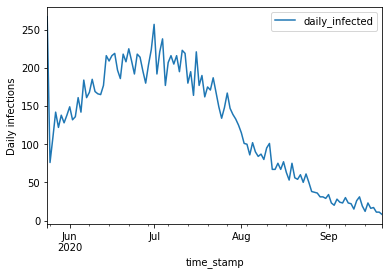

In [54]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

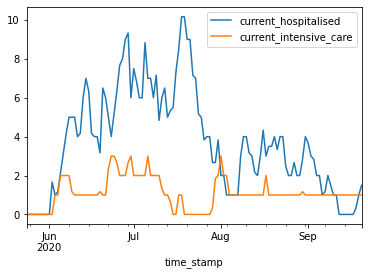

In [55]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [56]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-01-28 14:03:37,121 - june.records.records_reader - INFO - Loading infections table
2022-01-28 14:03:37,156 - june.records.records_reader - INFO - Loading population table
2022-01-28 14:03:37,216 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-28 14:03:37,227 - june.records.records_reader - INFO - Loading geography table
2022-01-28 14:03:37,254 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [57]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-01-28 14:03:37,274 - june.records.records_reader - INFO - Loading deaths table
2022-01-28 14:03:37,282 - june.records.records_reader - INFO - Loading population table
2022-01-28 14:03:37,341 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-28 14:03:37,346 - june.records.records_reader - INFO - Loading geography table
2022-01-28 14:03:37,371 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [58]:
age_bins = (0,20,60,100)

In [59]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [60]:
people_df = read.table_to_df('population')

In [61]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

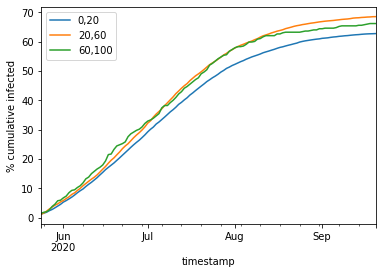

In [62]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [63]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

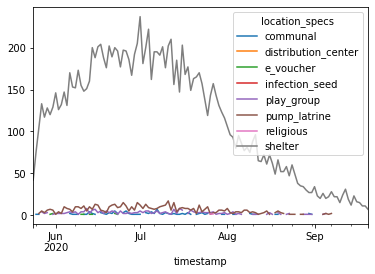

In [64]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

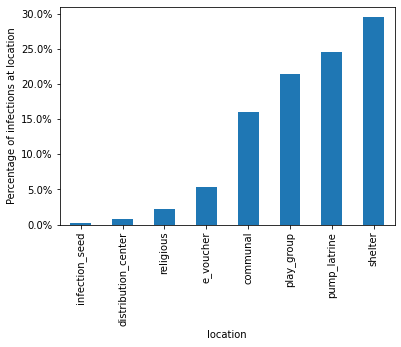

In [65]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')